In [1]:
import numpy as np
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn import svm
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [3]:
def load_data(y):
    path = '../../data/std_data/'
    x_train_std = pd.read_pickle(path +'train/{}_x.pkl'.format(str(y))).values
    x_test_std = pd.read_pickle(path +'test/{}_x.pkl'.format(str(y))).values
    y_train = pd.read_pickle(path +'train/{}_y.pkl'.format(str(y))).values
    y_test = pd.read_pickle(path +'test/{}_y.pkl'.format(str(y))).values
    features = pd.read_pickle(path +'train/{}_x.pkl'.format(str(y))).columns
    return x_train_std, x_test_std, y_train, y_test, features

In [6]:
def plot_roc_curve(fpr, tpr, auc):
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

In [9]:
def create_models():
    lr = LogisticRegression(class_weight="balanced", solver="liblinear",  penalty="l2", C=0.0001)
    
    sv = svm.SVR(kernel="poly",
                                 degree=8,
                                 gamma=0.03521735642853326,
                                 coef0=0.34010389238140537,
                                 tol=1e-05,
                                 C=0.001,
                                 epsilon=0.14620884632948022,
                                verbose=True,)

    xgboost = xgb.XGBRegressor(silent= True, 
                           max_depth=1,
                           learning_rate=0.14544434403253392,
                           n_estimators = 72,
                           gamma=0.4356018082020117,
                           reg_lambda=2.931451663505623,
                           reg_alpha=0.19045302677956732)

    lgbm = lgb.LGBMRegressor(
        verbosity=1,
        boost_from_average='true',
        metric='auc',
        bagging_freq=5,
        max_depth=19,
        learning_rate=0.09802221664336347,
        n_estimators=703,
        subsample=0.7596658467659505,
        reg_lambda=0.4087114877863393,  
    )
    
    lda = LDA(solver="eigen", shrinkage=1)

    estimators_rgs = [('sv', sv), ('xgboost', xgboost), ('lgbm', lgbm)]
    
    return estimators_rgs

In [10]:
def main():
    
    
    path = '../../data/dataframes/std_data/'
#     df =  pd.read_pickle('../../data/dataframes/unificated_data_set.pkl')
    
    cm_all = np.zeros((2, 2))
    
    # 予測した確率全体を格納
    probs_all = np.array([])
    y_true_all = np.array([])
    
    for y in range(1978, 2020):
        
        # データの生成
        x_train, x_test, y_train, y_test, features = load_data(y)
       
        # 学習
        estimators= create_models()
        
        vr = VotingRegressor(estimators)

        vr.fit(x_train, y_train)
        
        # 予測(確率)
        probs = vr.predict(x_test)
        probs_all = np.hstack((probs_all, probs))
        y_true_all = np.hstack((y_true_all, y_test))
        
        print(probs)

        # 混同行列
        y_pred = np.where((probs ==  max(probs)), 1, 0) #確率→0/1
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cm_all += cm
    
    auc = roc_auc_score(y_true_all, probs_all)
    fpr, tpr, thresholds = roc_curve(y_true_all, probs_all)
    
    plot_roc_curve(fpr, tpr, auc)
    
    print("len: {0} , {1}".format(len(y_true_all), len(probs_all) ))
    print("confusion_matrix: ")
    print(cm_all)
    print("AUC: ")
    print(auc)
    print()
    return

[LibSVM][0.24265484 0.12292849 0.0808274  0.12345066 0.08915181]
[LibSVM][0.3174956  0.07700879 0.1027298  0.22382121 0.10757573]
[LibSVM][0.200123   0.29343527 0.14071987 0.22888646 0.07678397]
[LibSVM][0.0252648  0.2114061  0.09127731 0.08576803 0.26429916]
[LibSVM][0.23877467 0.4271     0.15355391 0.25747094 0.07983452]
[LibSVM][0.35077026 0.09300522 0.08888738 0.06812772 0.13435625]
[LibSVM][0.09477487 0.16882009 0.12894777 0.24043363 0.12966311]
[LibSVM][0.19744781 0.14531987 0.29326043 0.13327864 0.02843674]
[LibSVM][0.09791697 0.086035   0.18610589 0.26291487 0.25750697]
[LibSVM][0.17545678 0.13292764 0.08830559 0.07131929 0.23779861]
[LibSVM][0.43819207 0.12449298 0.08821565 0.14148995 0.14617843]
[LibSVM][0.09232227 0.15372838 0.08916982 0.28300013 0.1475299 ]
[LibSVM][0.43686886 0.07561549 0.17435653 0.18610939 0.09113189]
[LibSVM][0.39362435 0.17614889 0.10102213 0.08352102 0.11812703]
[LibSVM][0.63122642 0.23174917 0.16922684 0.15574813 0.08513344]
[LibSVM][0.58894823 0.169

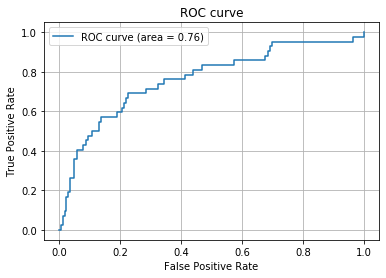

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC: 
0.7633136094674556



In [11]:
main()